# Preprocessing & Training - Billboard Hot 100 & Spotify Track Data

## 1.0 Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
#unique song data
songs = pd.read_csv('../data/processed/songs_eda', index_col=0)
#genres by song
genres = pd.read_csv('../data/processed/genres_eda', index_col=0)

### 1.1 Unique Song Data

In [3]:
songs.head()

,Date,BB_Title,BB_Artist,PeakPos,Weeks,SP_Title,SP_Artist,SP_id,Genres,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6,STAY (with Justin Bieber),The Kid LAROI,5HCyWlXZPP0y6Gqq8TgA20,australian hip hop,0.591,...,-5.484,1.0,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2021-08-28,Bad Habits,Ed Sheeran,2,8,Bad Habits,Ed Sheeran,6PQ88X9TkUIAUIZJHW2upE,"pop,uk pop",0.808,...,-3.712,0.0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,2021-08-28,Good 4 U,Olivia Rodrigo,1,14,good 4 u,Olivia Rodrigo,4ZtFanR9U6ndgddUvNcjcG,pop,0.563,...,-5.044,1.0,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1,Rumors (feat. Cardi B),Lizzo,6KgtcmCF9Ky68XC7ezxl3s,"dance pop,escape room,minnesota hip hop,pop,tr...",0.827,...,-5.524,0.0,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,"dance pop,pop",0.762,...,-3.541,1.0,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609 entries, 0 to 4608
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              4609 non-null   object 
 1   BB_Title          4609 non-null   object 
 2   BB_Artist         4609 non-null   object 
 3   PeakPos           4609 non-null   int64  
 4   Weeks             4609 non-null   int64  
 5   SP_Title          4609 non-null   object 
 6   SP_Artist         4609 non-null   object 
 7   SP_id             4609 non-null   object 
 8   Genres            4571 non-null   object 
 9   danceability      4609 non-null   float64
 10  energy            4609 non-null   float64
 11  key               4609 non-null   float64
 12  loudness          4609 non-null   float64
 13  mode              4609 non-null   float64
 14  speechiness       4609 non-null   float64
 15  acousticness      4609 non-null   float64
 16  instrumentalness  4609 non-null   float64


#### 1.1.2 Song Attributes Only

In [5]:
song_atts = songs.drop(columns=['Date','Weeks','SP_Title','SP_Artist','SP_id','Genres'])

song_atts.head()

,BB_Title,BB_Artist,PeakPos,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Stay,The Kid LAROI & Justin Bieber,1,0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,Bad Habits,Ed Sheeran,2,0.808,0.897,11.0,-3.712,0.0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,Good 4 U,Olivia Rodrigo,1,0.563,0.664,9.0,-5.044,1.0,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,Rumors,Lizzo Featuring Cardi B,4,0.827,0.731,4.0,-5.524,0.0,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,Kiss Me More,Doja Cat Featuring SZA,3,0.762,0.701,8.0,-3.541,1.0,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


### 1.2 Genres Data

In [6]:
genres.head()

,BB_Title,BB_Artist,Genres
0,Stay,The Kid LAROI & Justin Bieber,australian hip hop
1,Bad Habits,Ed Sheeran,pop
2,Bad Habits,Ed Sheeran,uk pop
3,Good 4 U,Olivia Rodrigo,pop
4,Rumors,Lizzo Featuring Cardi B,dance pop


#### 1.2.2 Genres Data, Categorical Data Converted to Numeric

In [7]:
counts = genres['Genres'].value_counts()
counts

pop                   1661
rap                   1540
dance pop             1064
trap                   973
hip hop                955
                      ... 
classic girl group       1
sudanese pop             1
french shoegaze          1
bubblegum pop            1
rock en espanol          1
Name: Genres, Length: 444, dtype: int64

In [8]:
#mask = genres['Genres'].isin(counts[counts < 10].index)
#genres['Genres'][mask] = 'Other'

#genres[genres.Genres == 'Other'].shape[0]

In [9]:
genres['Genres'] = genres['Genres'].fillna('Unknown')
genres.Genres.value_counts()

pop                   1661
rap                   1540
dance pop             1064
trap                   973
hip hop                955
                      ... 
classic girl group       1
sudanese pop             1
french shoegaze          1
bubblegum pop            1
chicago soul             1
Name: Genres, Length: 445, dtype: int64

In [10]:
#this approach using pd.get_dummies
#genre_dummies = pd.concat([genres, pd.get_dummies(data=genres.Genres)],axis=1)\
#                .groupby(by=['BB_Title','BB_Artist'],as_index=False).sum()

#genre_dummies.head()

In [11]:
# this approach uses FeatureHasher
# UPDATE - powers of two
# features = 52
features = 256

model = FeatureHasher(n_features=features, input_type='string')
transformed_model = model.transform(genres.Genres)
transformed_model.toarray()

df = pd.DataFrame(transformed_model.toarray(), columns=['tm_'+str(i) for i in range(features)])
#df

In [12]:
genre_hashed = pd.concat([genres, df], axis=1).groupby(by=['BB_Title','BB_Artist'],as_index=False).sum()

genre_hashed.head()

,BB_Title,BB_Artist,tm_0,tm_1,tm_2,tm_3,tm_4,tm_5,tm_6,tm_7,...,tm_246,tm_247,tm_248,tm_249,tm_250,tm_251,tm_252,tm_253,tm_254,tm_255
0,#Beautiful,Mariah Carey Featuring Miguel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0
1,#SELFIE,The Chainsmokers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,#thatPOWER,will.i.am Featuring Justin Bieber,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,$ave Dat Money,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,'Tis The Damn Season,Taylor Swift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
merged = pd.merge(song_atts, genre_hashed, how='left', on=['BB_Title','BB_Artist'])
#merged = pd.merge(song_atts, genre_dummies, how='left', on=['BB_Title','BB_Artist'])

merged

,BB_Title,BB_Artist,PeakPos,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tm_246,tm_247,tm_248,tm_249,tm_250,tm_251,tm_252,tm_253,tm_254,tm_255
0,Stay,The Kid LAROI & Justin Bieber,1,0.591,0.764,1.0,-5.484,1.0,0.0483,0.03830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bad Habits,Ed Sheeran,2,0.808,0.897,11.0,-3.712,0.0,0.0348,0.04690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Good 4 U,Olivia Rodrigo,1,0.563,0.664,9.0,-5.044,1.0,0.1540,0.33500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Rumors,Lizzo Featuring Cardi B,4,0.827,0.731,4.0,-5.524,0.0,0.0880,0.13000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Kiss Me More,Doja Cat Featuring SZA,3,0.762,0.701,8.0,-3.541,1.0,0.0286,0.23500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,How To Hate,Lil Wayne Featuring T-Pain,84,0.402,0.754,7.0,-5.955,1.0,0.0874,0.22200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4605,Nightmares Of The Bottom,Lil Wayne,90,0.810,0.577,8.0,-6.142,1.0,0.1490,0.00953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4606,President Carter,Lil Wayne,94,0.598,0.619,2.0,-7.465,0.0,0.2400,0.67400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4607,So Special,Lil Wayne Featuring John Legend,95,0.404,0.871,5.0,-4.606,0.0,0.1330,0.01180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.0 Train Test Split

In [14]:
X = merged.drop(columns=['PeakPos','BB_Title', 'BB_Artist'])
y = merged.PeakPos

#X = song_atts.drop(columns=['PeakPos','BB_Title', 'BB_Artist'])
#y = song_atts.PeakPos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
X_train.shape, X_test.shape

((3226, 269), (1383, 269))

## 3.0 Initial Metrics

In [16]:
def scores(model, scaled, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=5, print_score=True):
    if scaled == True:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)

    r2_tr = r2_score(y_train, y_tr_pred)
    r2_te = r2_score(y_test, y_te_pred)
    mae_tr = mean_absolute_error(y_train, y_tr_pred)
    mae_te = mean_absolute_error(y_test, y_te_pred)
    mse_tr = mean_squared_error(y_train, y_tr_pred)
    mse_te = mean_squared_error(y_test, y_te_pred)
    
    cv_results = cross_validate(model, X_train, y_train, cv=cv)
    cv_scores = cv_results['test_score']
    
    if print_score == True:
        print("R2 score: {0}, {1}".format(r2_tr, r2_te))
        print("MAE score: {0}, {1}".format(mae_tr, mae_te))
        print("MSE score: {0}, {1}".format(mse_tr, mse_te))
        print("CV scores: {0}".format(cv_scores))
        
    return cv_scores

### 3.1 Using the Training Set Mean

In [17]:
dumb_reg = DummyRegressor(strategy='mean')

In [18]:
dumb_reg_cv = scores(dumb_reg, scaled=False)

R2 score: 0.0, -1.7571827743534385e-05
MAE score: 25.512242824017044, 25.481120048198413
MSE score: 878.5760612298786, 873.4265627413887
CV scores: [-1.20710558e-03 -1.00329599e-02 -8.17048297e-04 -1.74837694e-05
 -9.83418535e-04]


### 3.2 Using Linear Regression

In [19]:
lm = LinearRegression()

In [20]:
lm_cv = scores(lm, scaled=True)

R2 score: 0.09207979992964077, 0.065906324902963
MAE score: 24.02187504171318, 24.376421306076892
MSE score: 797.6769532888596, 815.8478919798539
CV scores: [0.03494564 0.02360151 0.06770641 0.09195659 0.09450272]


### 3.3 Finding and Using K Best

In [21]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [22]:
#GridSearch to find KBest
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [23]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [24]:
lr_grid_cv.fit(X_train, y_train)

C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001ACBEBF8430>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [25]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [26]:
lr_grid_cv.best_params_

{'selectkbest__k': 252}

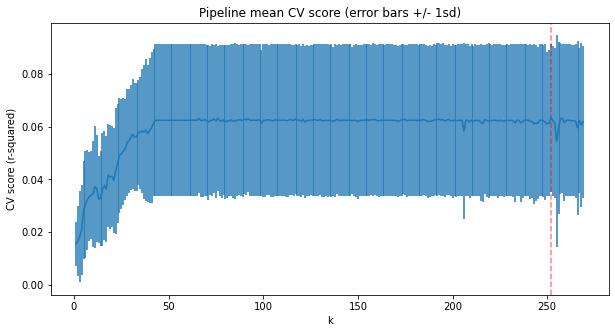

In [27]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [28]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
best_k

252

In [29]:
best_k_pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k = best_k),
    LinearRegression()
)

In [30]:
#already scaled no need to do it again
best_k_pipe_cv = scores(best_k_pipe, scaled = False)

C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


R2 score: 0.09216119760043895, 0.06620476861746849
MAE score: 24.02436199187808, 24.370227886350218
MSE score: 797.6054392438564, 815.587227892466
CV scores: [0.03494564 0.01445826 0.06835921 0.09152744 0.09465808]


C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jelic\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


### 3.4 Random Forest Model

In [31]:
RandomForestPipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

In [32]:
#already scaled no need to do it again
RF_cv = scores(RandomForestPipe, scaled = False)

R2 score: 0.871753832359713, 0.09028490562885494
MAE score: 8.88425294482331, 24.02303687635575
MSE score: 112.67401283323001, 794.5553661605204
CV scores: [0.07528159 0.03332156 0.10188708 0.07733222 0.07262294]


## 4.0 Visualizing Results

In [33]:
data = [dumb_reg_cv, lm_cv, best_k_pipe_cv, RF_cv]

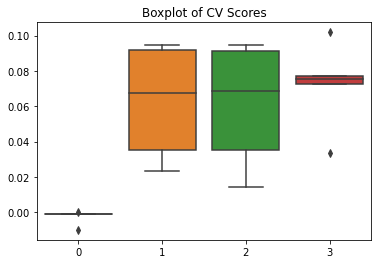

In [34]:
sns.boxplot(data=data)
plt.title("Boxplot of CV Scores")
plt.show()

## 5.0 Export Data

In [35]:
cwd = os.getcwd()

merged.to_csv(cwd + "/prepro-merged")

## Appendix - Optimizing the Number of Genre Features Used in Feature Hashing

In [36]:
cv_array = []

values_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]

for i in values_list:
    model = FeatureHasher(n_features=i, input_type='string')
    transformed_model = model.transform(genres.Genres)
    transformed_model.toarray()

    df = pd.DataFrame(transformed_model.toarray(), columns=['tm_'+str(i) for i in range(i)])
    genre_hashed = pd.concat([genres, df], axis=1).groupby(by=['BB_Title','BB_Artist'],as_index=False).sum()

    merged2 = pd.merge(song_atts, genre_hashed, how='left', on=['BB_Title','BB_Artist'])
    
    X = merged2.drop(columns=['PeakPos','BB_Title', 'BB_Artist'])
    y = merged2.PeakPos

    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

    #lm = LinearRegression()
    #lm_cv = scores(lm, scaled=True, X_train=X_train2, y_train=y_train2, X_test=X_test2, y_test=y_test2, print_score=False)
    #cv_array.append(lm_cv)
    
    rf = RandomForestRegressor(random_state=42)
    rf_cv = scores(rf, scaled=True, X_train=X_train2, y_train=y_train2, X_test=X_test2, y_test=y_test2, print_score=False)
    cv_array.append(rf_cv)

In [37]:
enumerate_list = list(enumerate(cv_array, 1))

In [38]:
max_mean = 0
good_cv_array = []
index_array = []

for i,t in enumerate_list:
    if t.mean() > max_mean:
        max_mean = t.mean()
        max_mean_index = i
    if t.mean() > 0.05:
        good_cv_array.append(t)
        index_array.append(i)

#good_cv_array
index_array

[3, 4, 5, 6, 7, 8, 9]

In [39]:
max_mean_index, max_mean

(8, 0.07225352252289521)

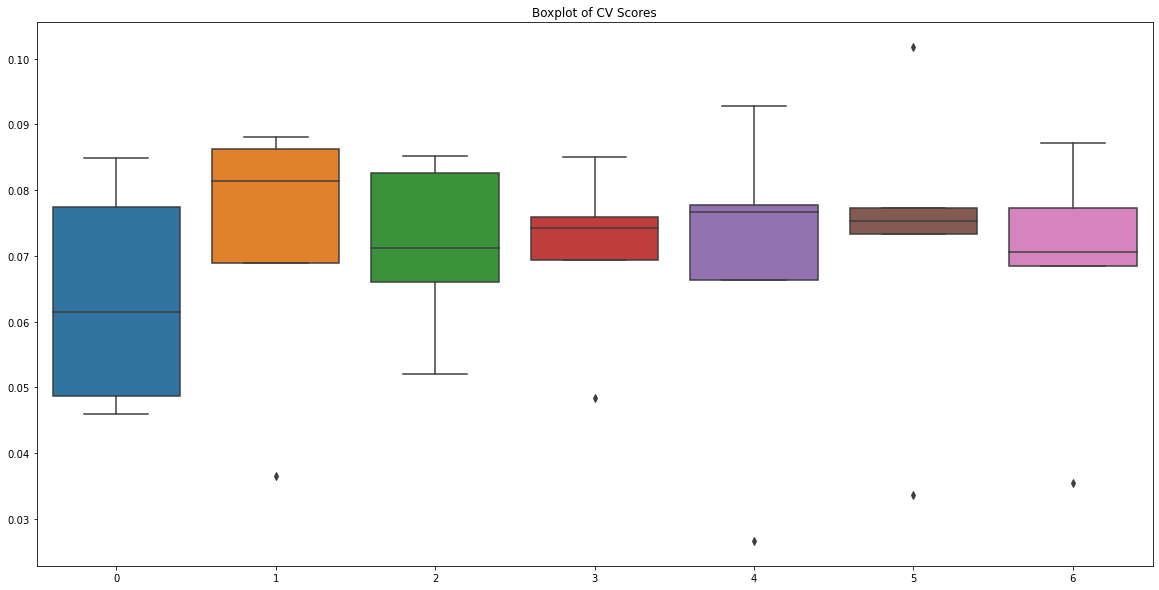

In [40]:
plt.subplots(figsize=(20, 10))
plt.title("Boxplot of CV Scores")
sns.boxplot(data=good_cv_array)
plt.show()